# <ins>Predicting Poetic Movements</ins>

## Modeling

### Using Naive Bayes, Decision Tree, Random Forest, and SVM

### NOTE: Currently working on revamping/organizing. Thank you for understanding :)

## Table of contents

1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Preparing the data](#Step-1:-Preparing-the-data)
    
    - [Multicollinearity](#Multicollinearity)
    - [Dealing with outliers](#Dealing-with-outliers)
    - [Save/Load DataFrame](#💾-Save/Load-DataFrame)
    - [Train-test split](#Train-test-split)
    - [Vectors DataFrame](#Vectors-DataFrame)
    - [Combo DataFrame](#Combo-DataFrame)
    
    
5. [Step 2: Modeling](#Step-2:-Modeling)

    - [Baseline model (Naive Bayes)](#Baseline-model-(Naive-Bayes))
    - [K-Nearest Neighbors](#K-Nearest-Neighbors)
    - [Decision Tree](#Decision-Tree)
    - [Random Forest](#Random-Forest)
    - [SVM](#SVM)
        - [Doc2Vec](#Doc2Vec)
        
        - [Parameter tuning](#Parameter-tuning)
        - [Train final model](#Train-final-model)
    
    
6. [Step 3: Reproducibility](#Step-3:-Reproducibility)

    - [NLP + Model version](#NLP-+-Model-version)
    - [Model only version](#Model-only-version)
    
    
7. [Conclusions](#Conclusions)
8. [Acknowledgements](#Acknowledgements)

## Introduction

[[go back to the top](#Predicting-Poetic-Movements)]

After [scraping](01_webscraping.ipynb) PoetryFoundation.org for genre-labeled poems and [cleaning](02_data_cleaning.ipynb), I used [natural language processing (NLP)](03_nlp_features_eda.ipynb) techniques to analyze poetic structure across poetic genres and movements. 

Through text processing, exploratory data analysis, and feature engineering, I looked for insights into how poetic structure, word usage, lexical richness, and sentiment relate to the genre of a poem.

In this notebook, I will create predictive models that classify poems into one of four umbrella movements: *Avant-Garde*, *Metropolitan*, *Modern*, or *Pre-1900*. This will help provide further insight and confirm my findings during EDA.

The ultimate goal is to create a recommendation system that compares poem similarities and recommends individual poems to users. *(NOTE: To skip to the recommendation system notebook, click [here](05_recommendation_system.ipynb))*.

## The problem domain

[[go back to the top](#Predicting-Poetic-Movements)]

Within written media, poetry is often regarded as enigmatic, frivolous, or too niche. As a result, poems (even by established poets) are often overlooked by larger publishers and literature-focused websites alike. (The anti-capitalist nature of poetry may play a role here as well). There are services for rating and recommending entire books (including poetry collections, to be fair) like GoodReads, Amazon, or Bookish, but to my knowledge, there aren't any sites or services that recommend poems on an individual level.

With this in mind, I wondered how poem recommendation may even work. One often finds a genre or two that they like and searches that out, but there must be elements of poetry that transcend genre. If there are, machine learning seems like a perfect tool to use to find them. As a poet and writer, I am interested in creating something that will allow me to discover genres and movements that I may have previously ignored. I can do this by using poems I already know and enjoy to find similar poems from genres I may not know as well.

## Required libraries

[[go back to the top](#Predicting-Poetic-Movements)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. Libraries within this category that I'll be using are:

- **numpy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **seaborn**: Advanced statistical plotting library.
- **scipy**: The essential statistical analysis package in Python.
- **collections**: A package with specialized and higher-performance data structures.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages that you may have to install:

- **nltk**: The essential natural language processing package.
- **gensim**: A more specialized natural language processing package.
- **pickle**: Package to save a file as a byte stream.
- **gzip**: Package to compress/unpack files.

Finally, included within the repository, and necessary to run this workbook, is:
- **[functions](functions.py)**: Custom functions that I built for this project.

Required within the functions file are:
- **itertools**: An package aiding in advanced iteration techniques.
- **regex**: The essential string matching and capturing package.
- **string**: A package with string-specific operations and characters.
- **pronouncing**: A package utilizing the CMU Pronouncing Dictionary that can break language down by syllable, rhyme, and meter.
- **textblob**: A supplementary package to enhance the nltk package.

In [148]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

# text processing
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# from gensim.models import Word2Vec, KeyedVectors

# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Bidirectional
# from keras.layers.embeddings import Embedding
# from keras.preprocessing import sequence

# miscellany
import os
import time
from tqdm import tqdm
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore sklearn/tensorflow warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Step 1: Preparing the data

[[go back to the top](#Predicting-Poetic-Movements)]

- Look for any highly correlated variables, to fight against the curse of dimensionality.
- Deal with any outlier data.

#### 💾 Load DataFrame

In [92]:
# uncomment to load
with gzip.open('data/poetry_movements_df.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [93]:
df.columns

Index(['poet', 'poem_url', 'title', 'poem_lines', 'poem_string', 'genre',
       'movement', 'clean_lines', 'num_lines', 'lines_titled', 'num_words',
       'avg_len_line', 'string_titled', 'sentiment_polarity_score',
       'sentiment_polarity', 'sentiment_subjectivity_score', 'num_end_rhymes',
       'end_rhyme_ratio', 'end_rhyme', 'avg_syllables_word',
       'lexical_richness', 'string_cleaned'],
      dtype='object')

In [94]:
# check out the class balance
df.movement.value_counts(normalize=True)

modern          0.288832
metropolitan    0.248665
pre_1900        0.240771
avant_garde     0.221732
Name: movement, dtype: float64

### Multicollinearity

[[go back to the top](#Predicting-Poetic-Movements)]

In [95]:
# list of continuous variables
cont_cols = [
    'num_lines', 'num_words', 'avg_len_line', 
    'sentiment_polarity_score', 'sentiment_subjectivity_score', 
    'num_end_rhymes', 'end_rhyme_ratio', 'avg_syllables_word', 
    'lexical_richness'
]

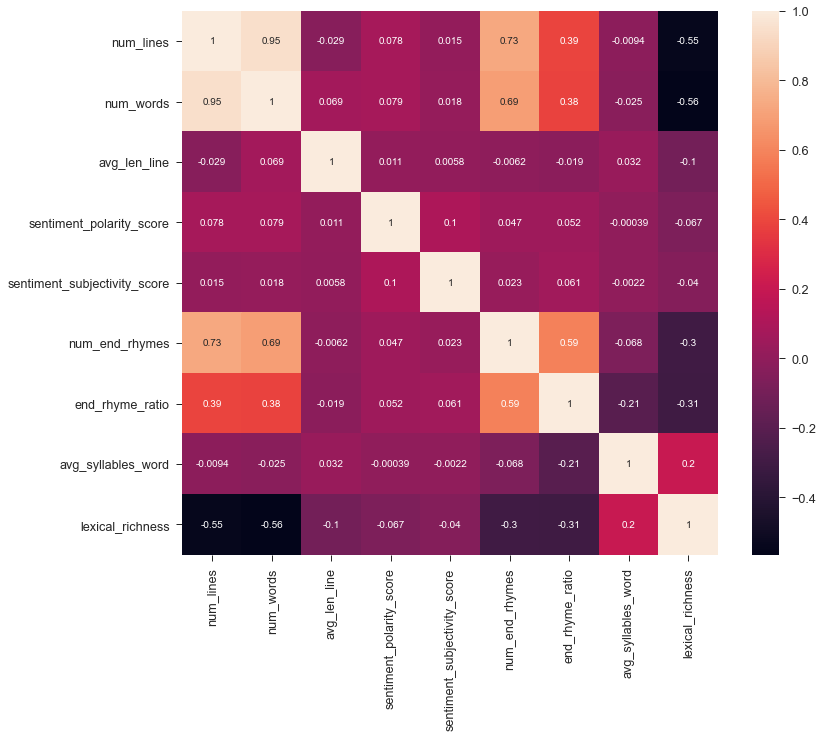

In [96]:
# plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_cols].corr(), annot=True);

- As seen in the [previous notebook](03_nlp_features_eda.ipynb), the number of lines (```num_lines```) and number of words (```num_words```) in a poem are very highly correlated.
    - I'll drop ```num_words```, as the number of lines is a more widely used metric for the length of a poem.
- The number of end rhymes (```num_end_rhymes```) is also rather highly correlated with ```num_lines```, so it's worth considering dropping that.
    - I found the ratio of end rhymes to the number of lines (```end_rhyme_ratio```) to be more statistically significant than the number of end rhymes, so I'd prefer to use that as my end rhyme metric anyway.

In [97]:
# new list of continuous variables
cont_cols = [
    'num_lines', 'avg_len_line', 'sentiment_polarity_score', 
    'sentiment_subjectivity_score', 'end_rhyme_ratio', 
    'avg_syllables_word', 'lexical_richness'
]

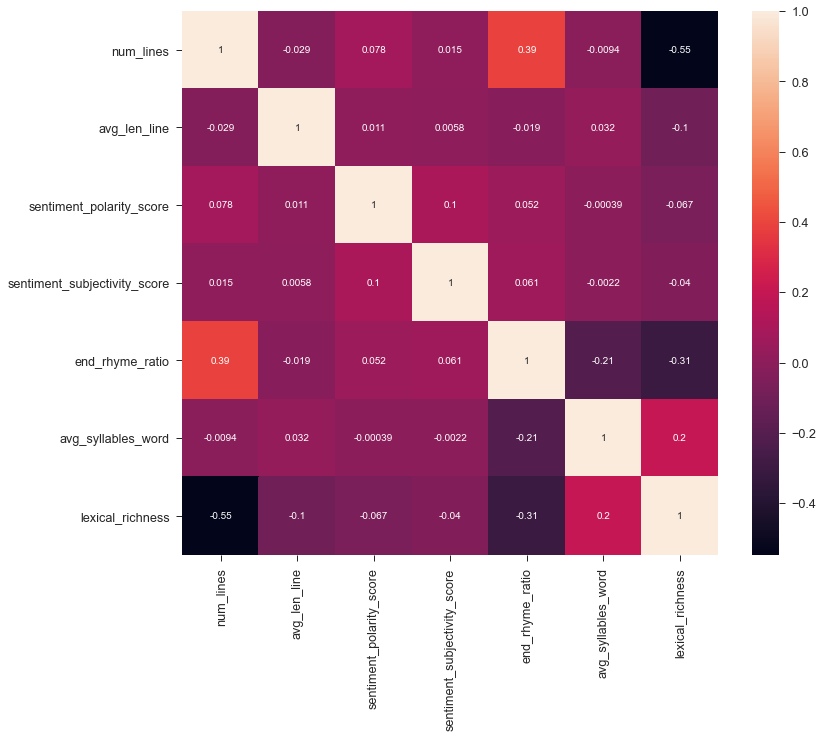

In [98]:
# plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_cols].corr(), annot=True);

### Dealing with outliers

[[go back to the top](#Predicting-Poetic-Movements)]

- Cap or floor outlier values as necessary.

In [99]:
# make a copy for which I can rein in outlier values
df_capped = df.copy()

In [100]:
# find the outlier thresholds (using winsorization)
min_thresh = df[cont_cols].quantile(0.05)
max_thresh = df[cont_cols].quantile(0.95)
print(min_thresh)
print('-' * 42)
print(max_thresh)

num_lines                       7.000000
avg_len_line                    3.346818
sentiment_polarity_score       -0.970270
sentiment_subjectivity_score    0.257885
end_rhyme_ratio                 0.000000
avg_syllables_word              1.092393
lexical_richness                0.440678
Name: 0.05, dtype: float64
------------------------------------------
num_lines                       131.700000
avg_len_line                      9.750000
sentiment_polarity_score          0.995900
sentiment_subjectivity_score      0.687500
end_rhyme_ratio                   1.009091
avg_syllables_word                1.372212
lexical_richness                  0.850402
Name: 0.95, dtype: float64


#### Number of lines

In [101]:
# descriptive stats
df.num_lines.describe()

count    4307.000000
mean       40.269561
std        63.118049
min         1.000000
25%        14.000000
50%        22.000000
75%        40.000000
max       892.000000
Name: num_lines, dtype: float64

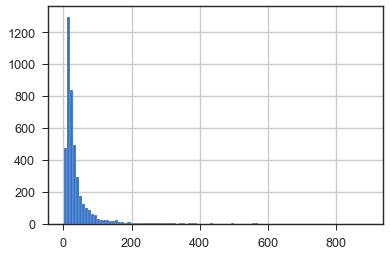

In [102]:
# current distribution
df.num_lines.hist(bins=100);

In [103]:
# cap/floor outliers
df_capped['num_lines'] = winsorizer(df['num_lines'])

# descriptive stats
df_capped['num_lines'].describe()

count    4307.000000
mean       34.295147
std        31.983861
min         7.000000
25%        14.000000
50%        22.000000
75%        40.000000
max       131.700000
Name: num_lines, dtype: float64

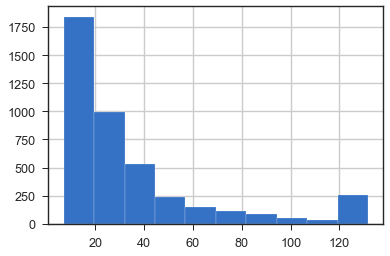

In [104]:
# new distribution
df_capped.num_lines.hist();

#### Average words per line

In [105]:
# descriptive stats
df.avg_len_line.describe()

count    4307.000000
mean        8.449181
std        37.933747
min         1.000000
25%         5.260870
50%         6.527778
75%         7.714286
max      1403.000000
Name: avg_len_line, dtype: float64

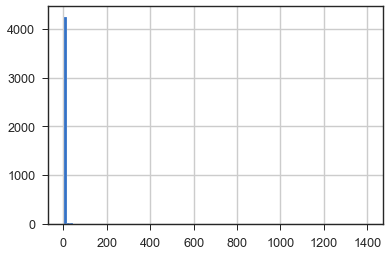

In [106]:
# current distribution
df.avg_len_line.hist(bins=100);

In [107]:
# cap/floor outliers
df_capped['avg_len_line'] = winsorizer(df['avg_len_line'])

# descriptive stats
df_capped['avg_len_line'].describe()

count    4307.000000
mean        6.494119
std         1.721049
min         3.346818
25%         5.260870
50%         6.527778
75%         7.714286
max         9.750000
Name: avg_len_line, dtype: float64

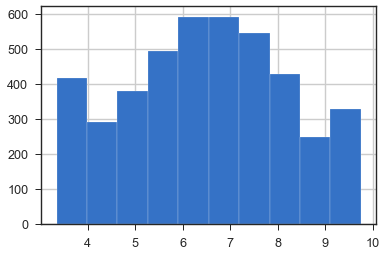

In [108]:
# new distribution
df_capped.avg_len_line.hist();

#### End rhyme ratio

In [109]:
# descriptive stats
df.end_rhyme_ratio.describe()

count    4307.000000
mean        0.302165
std         0.561589
min         0.000000
25%         0.000000
50%         0.127389
75%         0.416667
max        13.846154
Name: end_rhyme_ratio, dtype: float64

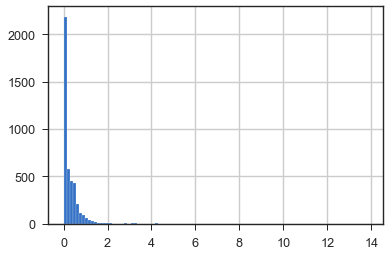

In [110]:
# current distribution
df.end_rhyme_ratio.hist(bins=100);

In [111]:
# cap/floor outliers
df_capped['end_rhyme_ratio'] = winsorizer(df['end_rhyme_ratio'])

# descriptive stats
df_capped['end_rhyme_ratio'].describe()

count    4307.000000
mean        0.254074
std         0.293332
min         0.000000
25%         0.000000
50%         0.127389
75%         0.416667
max         1.009091
Name: end_rhyme_ratio, dtype: float64

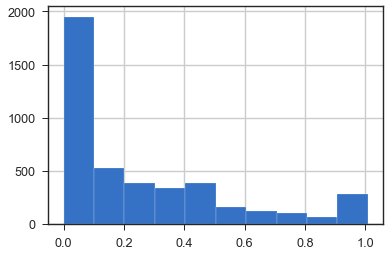

In [112]:
# new distribution
df_capped.end_rhyme_ratio.hist();

#### Average number of syllables per word

In [113]:
# descriptive stats
df.avg_syllables_word.describe()

count    4307.000000
mean        1.214609
std         0.087841
min         1.000000
25%         1.155752
50%         1.204545
75%         1.261905
max         1.771930
Name: avg_syllables_word, dtype: float64

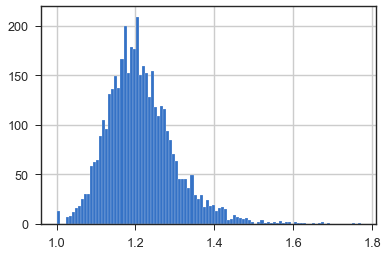

In [114]:
# current distribution
df.avg_syllables_word.hist(bins=100);

In [115]:
# cap/floor outliers
df_capped['avg_syllables_word'] = winsorizer(df['avg_syllables_word'])

# descriptive stats
df_capped['avg_syllables_word'].describe()

count    4307.000000
mean        1.212364
std         0.075228
min         1.092393
25%         1.155752
50%         1.204545
75%         1.261905
max         1.372212
Name: avg_syllables_word, dtype: float64

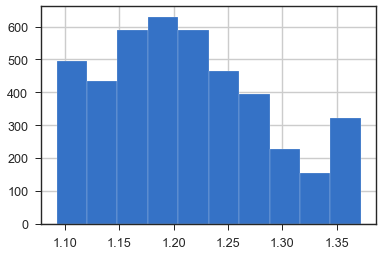

In [116]:
# new distribution
df_capped.avg_syllables_word.hist();

#### Lexical richness

In [117]:
# descriptive stats
df.lexical_richness.describe()

count    4307.000000
mean        0.657667
std         0.125099
min         0.066667
25%         0.580302
50%         0.666667
75%         0.740260
max         1.000000
Name: lexical_richness, dtype: float64

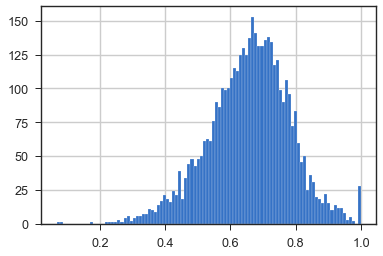

In [118]:
# current distribution
df.lexical_richness.hist(bins=100);

In [119]:
# cap/floor outliers
df_capped['lexical_richness'] = winsorizer(df['lexical_richness'])

# descriptive stats
df_capped['lexical_richness'].describe()

count    4307.000000
mean        0.658047
std         0.111326
min         0.440678
25%         0.580302
50%         0.666667
75%         0.740260
max         0.850402
Name: lexical_richness, dtype: float64

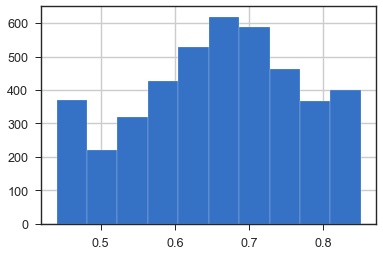

In [120]:
# new distribution
df_capped.lexical_richness.hist();

#### Subjectivity score

In [121]:
# descriptive stats
df.sentiment_subjectivity_score.describe()

count    4307.000000
mean        0.478008
std         0.135322
min         0.000000
25%         0.410284
50%         0.484470
75%         0.550000
max         1.000000
Name: sentiment_subjectivity_score, dtype: float64

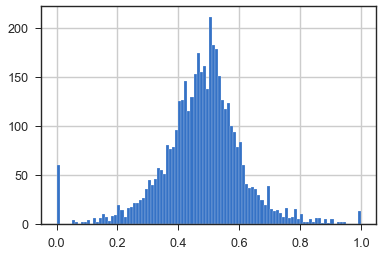

In [122]:
# current distribution
df.sentiment_subjectivity_score.hist(bins=100);

In [123]:
# cap/floor outliers
df_capped['sentiment_subjectivity_score'] = winsorizer(df['sentiment_subjectivity_score'])

# descriptive stats
df_capped['sentiment_subjectivity_score'].describe()

count    4307.000000
mean        0.479417
std         0.109112
min         0.257885
25%         0.410284
50%         0.484470
75%         0.550000
max         0.687500
Name: sentiment_subjectivity_score, dtype: float64

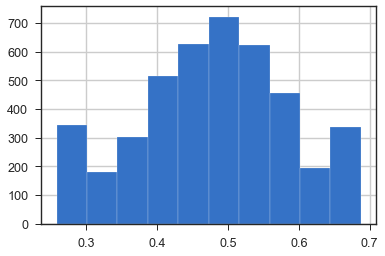

In [124]:
# new distribution
df_capped.sentiment_subjectivity_score.hist();

### 💾 Save/Load DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

In [125]:
# # uncomment to save
# with gzip.open('data/poetry_movements_df_capped.pkl', 'wb') as goodbye:
#     pickle.dump(df_capped, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/poetry_movements_df_capped.pkl', 'rb') as hello:
#     df_capped = pickle.load(hello)

### Train-test split

[[go back to the top](#Predicting-Poetic-Movements)]

- Create features DataFrame and target series.
    - While removing stop words was helpful for EDA in the [previous notebook](#03_nlp_features_eda.ipynb#Step-4:-Natural-language-processing), I'll refrain from doing that here, which should result in more accurate models. Using a TF-IDF vectorizer renders frequent words (i.e. words generally among the stop words list) less relevant.
- Use 75% of the data as a training set and 25% as a testing set.
- Since I want to see if my engineered features improve my models beyond those using only word vectors, I'll also create separate vector-only training and testing sets.
    - Scale my engineered features.
    - Vectorize using a TF-IDF vectorizer.
    
#### Features and target

In [126]:
# create features dataframe
X = df_capped[
    ['num_lines', 'avg_len_line', 'sentiment_polarity_score', 
     'sentiment_subjectivity_score', 'end_rhyme_ratio', 
     'avg_syllables_word', 'lexical_richness']
]

# assign target variable
y = df_capped['movement']

In [252]:
# list of classes that will be useful for graphs later
classes = ['Avant-Garde', 'Metropolitan', 'Modern', 'Pre-1900']

In [127]:
# lowercase text without punctuation and contractions
X['string_processed'] = df_capped.string_titled.apply(simple_process)

In [128]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

print(f'Train shape (rows, columns): {X_train.shape}')
print(f'Test shape (rows, columns): {X_test.shape}')

Train shape (rows, columns): (3230, 8)
Test shape (rows, columns): (1077, 8)


#### Scale numerical data

In [129]:
# separate out numerical data
X_train_nums = X_train.drop(columns='string_processed')
X_test_nums = X_test.drop(columns='string_processed')

In [130]:
# instantiate scaler
scaler = MinMaxScaler()

# scale numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_nums.columns)

### Vectors DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

- Create a DataFrame of just word vectors (sparse), using TF-IDF Vectorizer.

In [131]:
%%time

# instantiate vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_train_vec_matrix = vectorizer.fit_transform(X_train.string_processed)
X_test_vec_matrix = vectorizer.transform(X_test.string_processed)

CPU times: user 778 ms, sys: 14.3 ms, total: 793 ms
Wall time: 793 ms


In [132]:
%%time

# convert tf-idf vectors into dataframe so I can better view feature importances
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec_matrix, columns=vectorizer.get_feature_names())
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec_matrix, columns=vectorizer.get_feature_names())

CPU times: user 23.3 s, sys: 134 ms, total: 23.4 s
Wall time: 23.5 s


### Combo DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

- Combine vectors DataFrame with scaled numerical DataFrame.

In [133]:
# combine the numerical and vector dataframes for both train and test sets
X_train_combo = pd.concat([X_train_scaled_df, X_train_vec], axis=1)
X_test_combo = pd.concat([X_test_scaled_df, X_test_vec], axis=1)

# Step 2: Modeling

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll test out untuned Bernoulli Naive Bayes and Decision Tree models on both my vectors-only set and vectors-plus-features set.
- After an initial run through our basic models, I'll tune parameters on the best model.
- Finally, I can train and save a final model.

## Baseline model (Naive Bayes)

[[go back to the top](#Predicting-Poetic-Movements)]

- First, I'll try a model using only the TF-IDF vectors.
- Then I'll try a model using both my numerical features and the TF-IDF vectors.

### Vectors only

In [134]:
%%time

# instantiate classifier
benaba_vec = BernoulliNB()

# fit it to training set
benaba_vec.fit(X_train_vec, y_train)

CPU times: user 5.71 s, sys: 747 ms, total: 6.45 s
Wall time: 5.99 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [135]:
%%time

# model predictions and printout
train_preds_bnb_vec, test_preds_bnb_vec = \
    predict(
        benaba_vec, 
        X_train_vec, y_train, 
        X_test_vec, y_test, 
        classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 0.6643962848297214
F1 score: 0.6713713631652958

-----TEST-----
Accuracy: 0.4568245125348189
F1 score: 0.4270771658947016

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

 avant_garde       0.77      0.13      0.22       239
metropolitan       0.67      0.35      0.46       268
      modern       0.36      0.86      0.50       311
    pre_1900       0.71      0.38      0.50       259

    accuracy                           0.46      1077
   macro avg       0.62      0.43      0.42      1077
weighted avg       0.61      0.46      0.43      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 30  31 171   7]
 [  7  94 160   7]
 [  2  13 269  27]
 [  0   3 157  99]]
CPU times: user 8.87 s, sys: 1.16 s, total: 10 s
Wall time: 8.7 s


- Not too bad for a baseline. Certainly better than just predicting 'modern', which would give you a 29% accuracy.
- That said, it is indeed overpredicting on 'modern'.
- It appears to be having the most trouble with Metropolitan poetry.

#### Feature importances

In [142]:
# function to print top 10 features for each class
print_nb_features(
            benaba_vec,
            X_train_vec,
            classes
        )

Avant-Garde:
aa, nikes, nihilist, nihil, nighty, nightwoods, nightwatchmans, nightsong, nightmares, nightmard

Metropolitan:
aa, modesty, modestly, modernest, moderately, moderate, modelled, mod, mocks, mockingbirds

Modern:
lenin, hd, scratchy, hazels, hazelnut, hazel, hazed, hazards, screamd, hazarded

Pre-1900:
lenin, milkpitcher, milkman, milker, militarisme, militant, milieus, milieu, miliar, milholland



- An interesting mix of words, many of which appear to be typos or perhaps part of a hyphenated word that ran onto a different line.

#### Confusion matrix

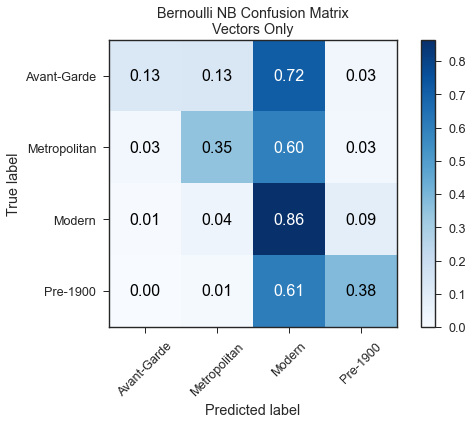

In [143]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_bnb_vec)

# plot as graph
plot_confusion_matrix(
    cm, 
    classes, 
    normalize=True,                   
    title='Bernoulli NB Confusion Matrix\nVectors Only', 
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/bnb_vec_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

### Vectors + numerical data

In [144]:
%%time

# instantiate classifier
benaba_combo = BernoulliNB()

# fit it to our training set
benaba_combo.fit(X_train_combo, y_train)

CPU times: user 11.2 s, sys: 1.95 s, total: 13.2 s
Wall time: 12.7 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [145]:
%%time

# model predictions and printout
train_preds_bnb_combo, test_preds_bnb_combo = \
    predict(
        benaba_combo, 
        X_train_combo, y_train, 
        X_test_combo, y_test, 
        classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 0.6684210526315789
F1 score: 0.6751999282476966

-----TEST-----
Accuracy: 0.4586815227483751
F1 score: 0.4296462820371316

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

 avant_garde       0.74      0.13      0.22       239
metropolitan       0.66      0.35      0.46       268
      modern       0.36      0.86      0.51       311
    pre_1900       0.71      0.38      0.50       259

    accuracy                           0.46      1077
   macro avg       0.62      0.43      0.42      1077
weighted avg       0.60      0.46      0.43      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 31  32 169   7]
 [  9  95 158   6]
 [  2  13 269  27]
 [  0   3 157  99]]
CPU times: user 15.9 s, sys: 2.83 s, total: 18.7 s
Wall time: 17.3 s


- Practically the same result; a very slight boost if anything.

#### Confusion matrix

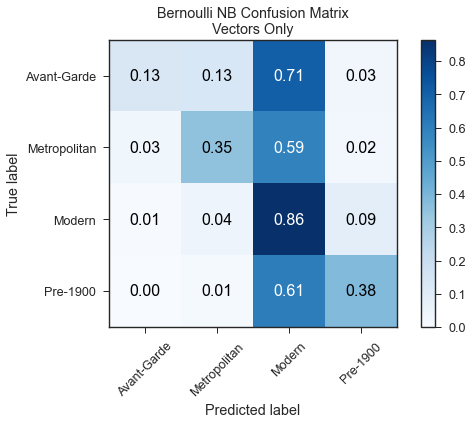

In [146]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_bnb_combo)

# plot as graph
plot_confusion_matrix(
    cm, 
    classes, 
    normalize=True,
    title='Bernoulli NB Confusion Matrix\nVectors Only', 
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/bnb_combo_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

- This confirms it is practically the same result.

#### Feature importances

In [147]:
# function to print top 10 features for each class
print_nb_features(
            benaba_combo,
            X_train_combo,
            classes
        )

Avant-Garde:
zz, slackend, impending, impend, impels, slackened, impediment, impedes, slackening, impede

Metropolitan:
lengthwise, modestly, modernest, moderately, moderate, modelled, mod, mocks, mockingbirds, mockingbird

Modern:
lengthwise, hazel, hazed, hazards, scraping, hazarded, scrappy, hazan, hayworth, haystraw

Pre-1900:
lengthwise, milkpitcher, milkman, milker, militarisme, militant, milieus, milieu, miliar, milholland



- Interestingly, these are still all word vectors, but different from the vectors-only model.

## K-Nearest Neighbors

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

In [150]:
# instantiate classifiers
knn_vec = KNeighborsClassifier()
knn_combo = KNeighborsClassifier()

⏰ NOTE: The next cell took me about 5 minutes to run.

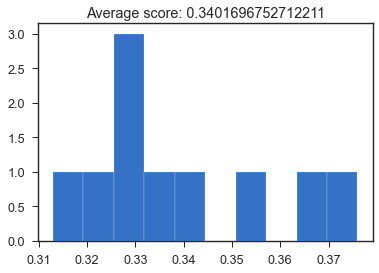

CPU times: user 2min 28s, sys: 2.97 s, total: 2min 31s
Wall time: 5min 34s


array([0.34081473, 0.32791069, 0.37598843, 0.33418527, 0.32975972,
       0.32500524, 0.31292064, 0.36944109, 0.35442761, 0.33124332])

In [152]:
%%time

# vectors only model
cv_plotter(knn_vec, X_train_vec, y_train)

⏰ NOTE: The next cell took me about 6 minutes to run.

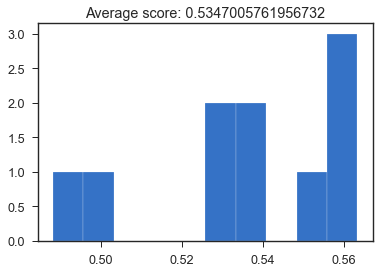

CPU times: user 2min 37s, sys: 5.59 s, total: 2min 42s
Wall time: 6min 26s


array([0.50270974, 0.52729918, 0.55621674, 0.56323718, 0.53661691,
       0.48830611, 0.53023397, 0.55724183, 0.55134632, 0.53379778])

In [153]:
%%time

# combo model
cv_plotter(knn_combo, X_train_combo, y_train)

- The combo data set performs better than the Naive Bayes model and far better than the vectors only set.
- First, I'll try to find the best value for *k*, then train a model.

### Vectors + numerical data

⏰ NOTE: The next cell took me about 40 minutes to run.

100%|██████████| 25/25 [39:38<00:00, 95.14s/it]


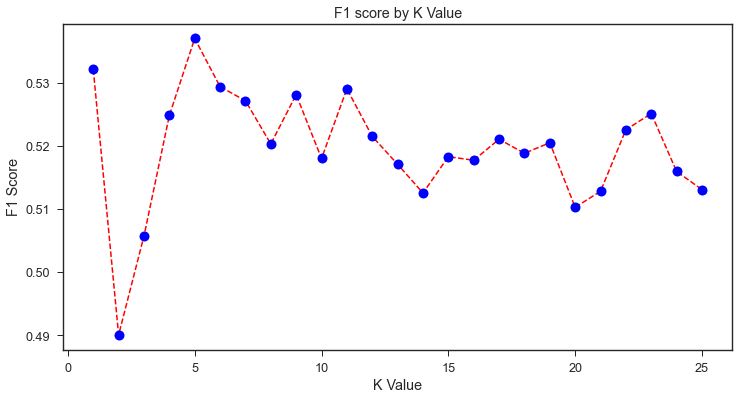

CPU times: user 3h 26min 28s, sys: 1min 57s, total: 3h 28min 26s
Wall time: 39min 38s


In [154]:
%%time

# create a container to track the scores
k_scores = []

# set up a loop to fit the model using a different values of k
# use at least 5 neighbors since there are 4 classes
k_range = list(range(5, 15))
for k in tqdm(k_range):
    
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    # fit the model and get the score on an evaluation metric
    knn.fit(X_train_combo, y_train)
    y_pred = knn.predict(X_test_combo)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # add to container
    k_scores.append(f1)
    
# plot a graph
plt.figure(figsize=(12, 6))  
plt.plot(k_range, k_scores, color='red', linestyle='dashed', 
         marker='o', markerfacecolor='blue', markersize=10)
plt.title('F1 score by K Value')  
plt.xlabel('K Value')  
plt.ylabel('F1 Score') 
plt.show()

In [155]:
# five highest scores
sorted_scores = sorted(list(enumerate(k_scores, 1)), 
                       key=lambda tup: tup[1], 
                       reverse=True)
sorted_scores[:5]

[(5, 0.537095723460491),
 (1, 0.5321888160863517),
 (6, 0.5294555875763667),
 (11, 0.5291090099029194),
 (9, 0.5281936024573077)]

- After all that, the default of *k=5* appears to have the best results, so I'll train a model on that.

In [156]:
%%time

# instantiate the model
knn_combo = KNeighborsClassifier(
    n_neighbors=5, 
    n_jobs=-1)

# fit to the training set
knn_combo.fit(X_train_combo, y_train)

CPU times: user 18.2 s, sys: 2.29 s, total: 20.5 s
Wall time: 20.6 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

⏰ NOTE: The next cell took me about 5 minutes to run.

In [157]:
%%time

# model predictions and printout
train_preds_knn_combo, test_preds_knn_combo = \
    predict(
        knn_combo, 
        X_train_combo, y_train, 
        X_test_combo, y_test, 
        classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 0.7018575851393188
F1 score: 0.6998579791649526

-----TEST-----
Accuracy: 0.542246982358403
F1 score: 0.537095723460491

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

 avant_garde       0.48      0.64      0.55       239
metropolitan       0.48      0.49      0.49       268
      modern       0.52      0.38      0.44       311
    pre_1900       0.68      0.71      0.70       259

    accuracy                           0.54      1077
   macro avg       0.54      0.55      0.54      1077
weighted avg       0.54      0.54      0.54      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[152  51  26  10]
 [ 82 131  40  15]
 [ 64  70 117  60]
 [ 16  19  40 184]]
CPU times: user 31min 30s, sys: 10.2 s, total: 31min 41s
Wall time: 4min 47s


#### Confusion matrix

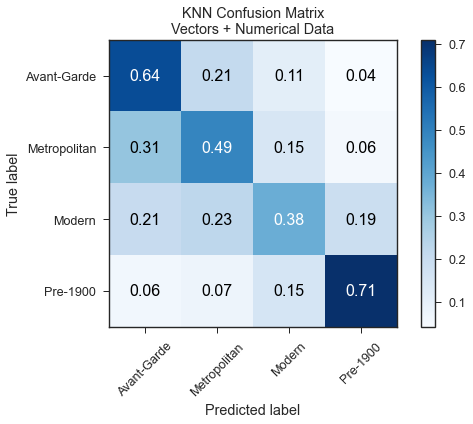

In [158]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_knn_combo)

# plot as graph
plot_confusion_matrix(
    cm, 
    classes, 
    normalize=True,
    title='KNN Confusion Matrix\nVectors + Numerical Data', 
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/knn_combo_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

- This is definitely better than the Naive Bayes model.
    - It predicts Modern a lot less. If anything, it has perhaps gone too far in the other direction.
    - Much better at predicting Avant-Garde, which is interesting. Perhaps this genre is quite clustered, as is Pre-1900 poetry.
    - Predictions seem fairly evenly spread.
    - Has trouble correctly predicting Metropolitan and Modern poetries.
    
- Pretty overfit.

## Decision Tree

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

In [159]:
# instantiate classifiers
tree_vec = DecisionTreeClassifier()
tree_combo = DecisionTreeClassifier()

⏰ NOTE: The next cell took me about 3 minutes to run.

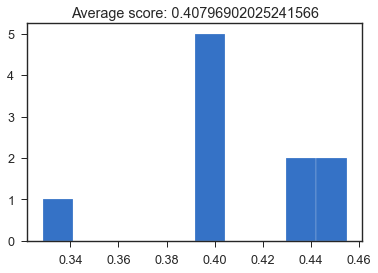

CPU times: user 2min 7s, sys: 2.28 s, total: 2min 9s
Wall time: 2min 52s


array([0.39324791, 0.43627475, 0.44322794, 0.39314971, 0.45503222,
       0.3284355 , 0.4297244 , 0.40297119, 0.39494517, 0.40268142])

In [160]:
%%time

# vectors only model
cv_plotter(tree_vec, X_train_vec, y_train)

⏰ NOTE: The next cell took me about 3 minutes to run.

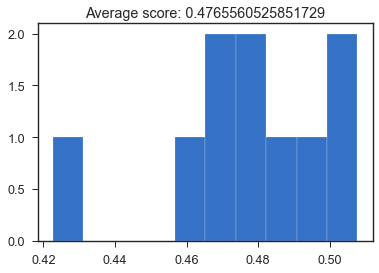

CPU times: user 2min 20s, sys: 2.12 s, total: 2min 22s
Wall time: 3min 10s


array([0.4227205 , 0.46148754, 0.46553784, 0.47484552, 0.49760022,
       0.46767073, 0.48851797, 0.49938643, 0.50770927, 0.4800845 ])

In [161]:
%%time

# combo model
cv_plotter(tree_combo, X_train_combo, y_train)

- A Decision Tree isn't shaping up to be a very good model; it is not much better than Naive Bayes and definitely worse than KNN.
- I'll keep it in mind if I need to check out feature importances, since KNN doesn't provide that information. I should be able to obtain those using Random Forest, however.

## Random Forest

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors-only model and a combo model.

In [170]:
# instantiate classifiers
forest_vec = RandomForestClassifier(random_state=42)
forest_combo = RandomForestClassifier(random_state=42)

⏰ NOTE: The next cell took me about 3 minutes to run.

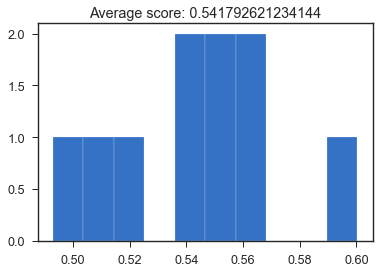

CPU times: user 2min 30s, sys: 2.16 s, total: 2min 32s
Wall time: 3min 27s


array([0.49299917, 0.60032873, 0.54740294, 0.53849322, 0.54688762,
       0.50396226, 0.56019266, 0.56076002, 0.54454966, 0.52234994])

In [171]:
%%time

# vectors only model
cv_plotter(forest_vec, X_train_vec, y_train)

⏰ NOTE: The next cell took me about 4 minutes to run.

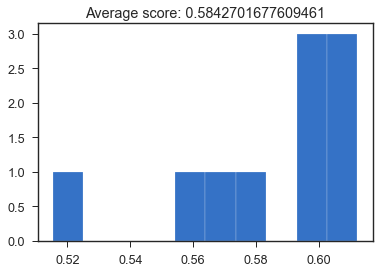

CPU times: user 2min 33s, sys: 2.21 s, total: 2min 35s
Wall time: 3min 40s


array([0.57693979, 0.60664972, 0.59447197, 0.60186352, 0.59851766,
       0.51540933, 0.60317161, 0.56264818, 0.61216458, 0.57086531])

In [172]:
%%time

# combo model
cv_plotter(forest_combo, X_train_combo, y_train)

- Including engineered features seems more promising, so I'll move ahead with this one.

### Vectors + numerical data

In [173]:
%%time

# instantiate the model
forest_combo = RandomForestClassifier(random_state=42)

# fit to the training set
forest_combo.fit(X_train_combo, y_train)

CPU times: user 21.4 s, sys: 1.49 s, total: 22.9 s
Wall time: 22.9 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [174]:
%%time

# model predictions and printout
train_preds_forest_combo, test_preds_forest_combo = \
    predict(
        forest_combo,
        X_train_combo, y_train, 
        X_test_combo, y_test, 
        classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 1.0
F1 score: 1.0

-----TEST-----
Accuracy: 0.5942432683379758
F1 score: 0.595190433315553

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

 avant_garde       0.59      0.47      0.52       239
metropolitan       0.57      0.48      0.52       268
      modern       0.49      0.69      0.57       311
    pre_1900       0.83      0.72      0.77       259

    accuracy                           0.59      1077
   macro avg       0.62      0.59      0.60      1077
weighted avg       0.61      0.59      0.60      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[112  52  70   5]
 [ 48 128  87   5]
 [ 29  39 214  29]
 [  1   5  67 186]]
CPU times: user 9.64 s, sys: 1.91 s, total: 11.5 s
Wall time: 11.6 s


#### Confusion matrix

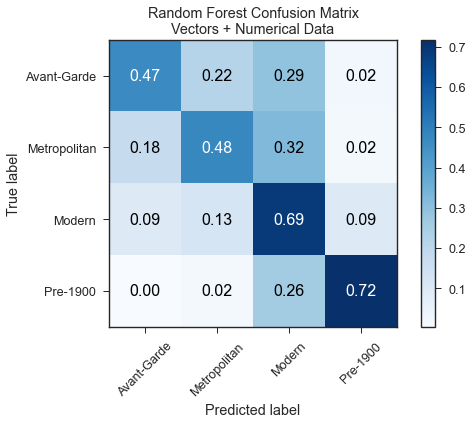

In [175]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_forest_combo)

# plot as graph
plot_confusion_matrix(
    cm, 
    classes, 
    normalize=True,
    title='Random Forest Confusion Matrix\nVectors + Numerical Data', 
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/rf_combo_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

- Much better overall F1 score, but I'm back to overpredicting Modern.
- Unlike KNN, however, this is very overfit, so tuning this would definitely be necessary.
- Still, this will be a great model to use to look at important features.

#### Feature importances

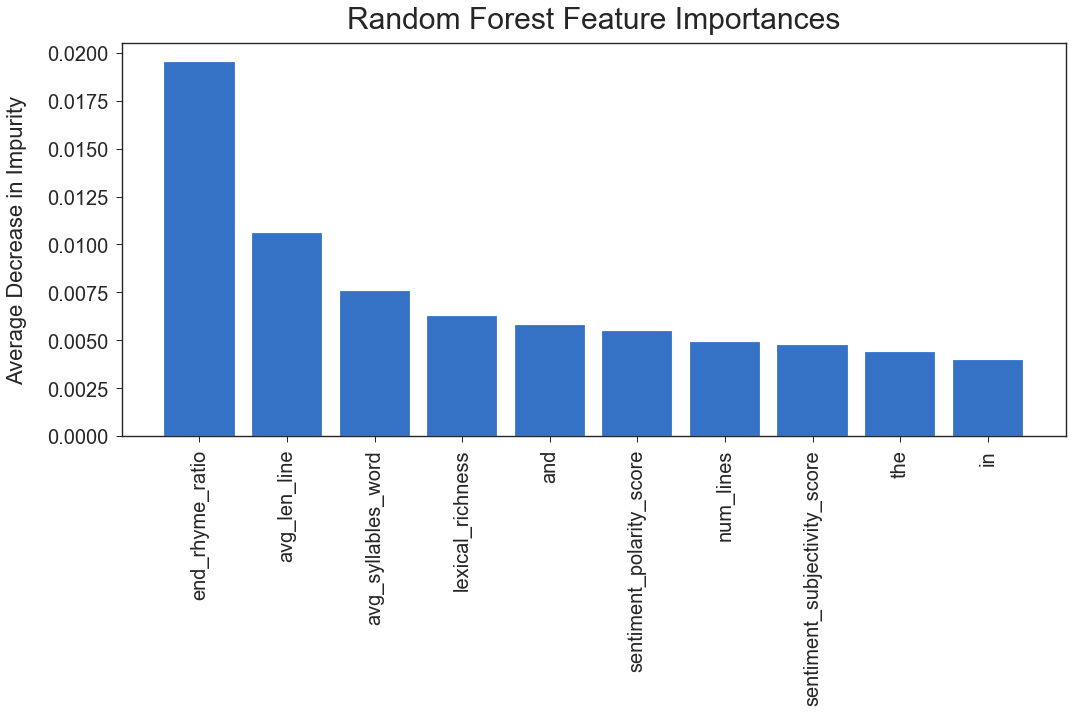

In [176]:
# top 10 features
plot_forest_features(
    forest_combo, 
    X_train_combo,
    to_print=False
)

- Mostly engineered features here, with the ratio of end rhymes to total lines have a large importance compared to the rest.
- Also, stop words seem important, perhaps meaning that some movements use more stop words than others.

## SVM

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

In [177]:
# instantiate classifiers
svm_vec = LinearSVC(random_state=42)
svm_combo = LinearSVC(random_state=42)

⏰ NOTE: The next cell took me about 3 minutes to run.

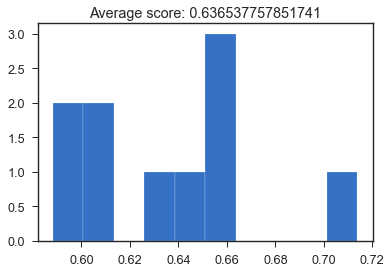

CPU times: user 2min 5s, sys: 1.76 s, total: 2min 7s
Wall time: 2min 43s


array([0.62761568, 0.71386136, 0.59946969, 0.64340131, 0.65450934,
       0.66156892, 0.58829792, 0.61299607, 0.65410261, 0.60955467])

In [178]:
%%time

# vectors only model
cv_plotter(svm_vec, X_train_vec, y_train)

⏰ NOTE: The next cell took me about 5 minutes to run.

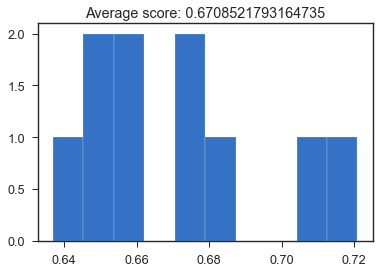

CPU times: user 2min 50s, sys: 4.56 s, total: 2min 55s
Wall time: 5min 3s


array([0.65097901, 0.70820609, 0.64683284, 0.68607899, 0.65457732,
       0.67129181, 0.66054012, 0.67212663, 0.72090737, 0.63698163])

In [179]:
%%time

# combo model
cv_plotter(svm_combo, X_train_combo, y_train)

- This is the best one yet! And I'm not surprised. SVM tends to work well with text classification and data that has fewer data points and lots of variables (i.e. sparse word vectors).
- Once again, my engineered features seem to help out the model, so I'll train a basic one here. Then I can focus on tuning parameters.

### Vectors + numerical data

In [180]:
%%time

# instantiate the model
svm_combo = LinearSVC(random_state=42)

# fit to the training set
svm_combo.fit(X_train_combo, y_train)

CPU times: user 39.1 s, sys: 2.19 s, total: 41.3 s
Wall time: 41.5 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [181]:
%%time

# model predictions and printout
train_preds_svm_combo, test_preds_svm_combo = \
    predict(
        svm_combo, 
        X_train_combo, y_train, 
        X_test_combo, y_test, 
        classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 0.9990712074303405
F1 score: 0.9990713532528626

-----TEST-----
Accuracy: 0.6564531104921077
F1 score: 0.6552542692291389

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

 avant_garde       0.60      0.65      0.62       239
metropolitan       0.60      0.60      0.60       268
      modern       0.61      0.56      0.59       311
    pre_1900       0.81      0.84      0.83       259

    accuracy                           0.66      1077
   macro avg       0.66      0.66      0.66      1077
weighted avg       0.66      0.66      0.66      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[155  43  34   7]
 [ 50 160  50   8]
 [ 47  54 175  35]
 [  5  11  26 217]]
CPU times: user 10.8 s, sys: 2.27 s, total: 13.1 s
Wall time: 12 s


#### Confusion matrix

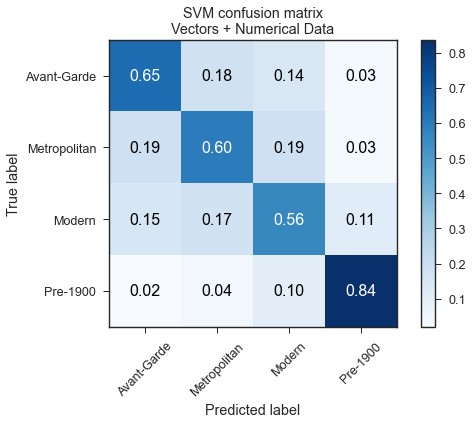

In [182]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_svm_combo)

# plot as graph
plot_confusion_matrix(
    cm, 
    classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/svm_combo_untuned_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

- Still overfit but a very good spread of predictions here compared to the other models.
    - Each category is correctly predicted at least half the time.
- Pre-1900 poetry is very easily recognized by the model.
    - Modern poetry appears to be the largest confusing factor here, so must share some similarities with Pre-1900 poetry. 
    - Avant-Garde and Metropolitan are hardly ever predicted for Pre-1900 poems, and Pre-1900 is hardly predicted for Metropolitan and Avant-Garde poems.
- As in the KNN, Avant-Garde has seen quite a boost, whereas Avant-Garde and Modern seem a little more difficult to correctly predict.

#### Feature importances

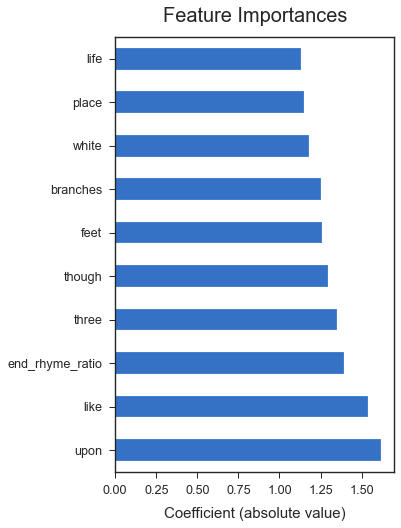

In [183]:
# top 10 features
svm_features(svm_combo, X_train_combo.columns)

- Only the ratio of end rhymes to total lines made it from my engineered features. 
- Mostly surprising words, *white* being the only word in the top 25 overall.

## Doc2Vec

[[go back to the top](#Predicting-Poetic-Movements)]

### Preparing the data
- Instead of using the MinMaxScaler, I'll rescale my engineered features using StandardScaler, since the document vectors appear to be more along that scale.
- Then I'll split the poems into a training and a testing corpus and create TaggedDocument objects needed by Doc2Vec, using only the training data.

In [184]:
# instantiate scaler
scaler = StandardScaler()

# scale numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_nums.columns)

In [185]:
# for train-test split
train_data = [poem.split() for poem in X_train.string_processed]
test_data = [poem.split() for poem in X_test.string_processed]

# prepare training data in doc2vec format
train_docs = [TaggedDocument((d), tags=[str(i)]) for i, d in enumerate(train_data)]

### Training a model
- I'll train the model on the training data and create vectors using the model for *both* the train set and the test set, which tends to prevent overfitting.
- After combining with my engineered features, I'll cross validate and train a model.

*NOTE: Much of this code is based on O'Reilly's* [Practical NLP](https://github.com/practical-nlp/practical-nlp/blob/master/Ch4/02_Doc2Vec_Example.ipynb).

⏰ NOTE: The next cell took me about 1 minute to run.

In [220]:
%%time

# train a doc2vec model, using only training data
model = Doc2Vec(vector_size=100, 
                alpha=0.025, 
                min_count=5,
                dm=1, epochs=100)

model.build_vocab(train_docs)
model.train(train_docs, 
            total_examples=model.corpus_count, 
            epochs=model.epochs)

CPU times: user 2min 3s, sys: 3.19 s, total: 2min 6s
Wall time: 56.8 s


In [221]:
# uncomment to save model
model.save('data/d2v.model')

# uncomment to load model
model = Doc2Vec.load('data/d2v.model')

⏰ NOTE: The next cell took me about 2 minutes to run.

In [222]:
%%time

# infer in multiple steps to get a stable representation. 
train_vecs = [model.infer_vector(words, epochs=100) for words in train_data]
test_vecs = [model.infer_vector(words, epochs=100) for words in test_data]

CPU times: user 1min 48s, sys: 149 ms, total: 1min 48s
Wall time: 1min 48s


In [223]:
# convert to dataframe
doc_train_vec = pd.DataFrame(train_vecs, columns=[f'docvec_{i}' for i in range(1,101)])
doc_test_vec = pd.DataFrame(test_vecs, columns=[f'docvec_{i}' for i in range(1,101)])

In [224]:
# combine with engineered features
doc_train_combo = pd.concat([X_train_scaled_df, doc_train_vecs], axis=1)
doc_test_combo = pd.concat([X_test_scaled_df, doc_test_vecs], axis=1)

# confirm good shape
doc_train_combo.shape, doc_test_combo.shape

((3230, 107), (1077, 107))

In [225]:
# instantiate classifiers
svm_doc_vec = LinearSVC(random_state=42)
svm_doc_combo = LinearSVC(random_state=42)

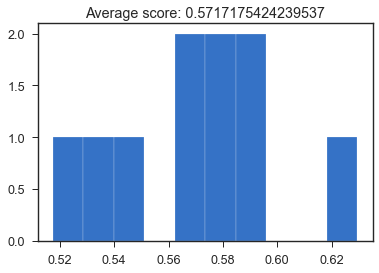

CPU times: user 208 ms, sys: 95.5 ms, total: 303 ms
Wall time: 9.14 s


array([0.54396083, 0.6294837 , 0.5174818 , 0.58224706, 0.58341119,
       0.59296374, 0.57294771, 0.53516307, 0.58628688, 0.57322945])

In [226]:
%%time

# vectors only model
cv_plotter(svm_doc_vec, doc_train_vec, y_train)

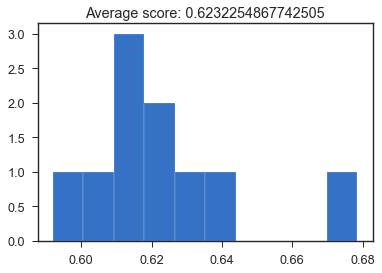

CPU times: user 167 ms, sys: 8.87 ms, total: 176 ms
Wall time: 8.02 s


array([0.60994154, 0.67852006, 0.60497097, 0.6297543 , 0.64293908,
       0.61370741, 0.62277134, 0.61535706, 0.59201775, 0.62227536])

In [227]:
%%time

# combo model
cv_plotter(svm_doc_combo, doc_train_combo, y_train)

- Once again, the combination of vectors and engineered features provides better F1 scores.

In [228]:
%%time

# instantiate the model
svm_doc_combo = LinearSVC(C=1, random_state=42)

# fit to the training set
svm_doc_combo.fit(doc_train_combo, y_train)

CPU times: user 2.6 s, sys: 4.86 ms, total: 2.61 s
Wall time: 2.61 s


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [229]:
%%time

# model predictions and printout
train_preds_svm_doc, test_preds_svm_doc = \
    predict(
        svm_doc_combo, 
        doc_train_combo, y_train, 
        doc_test_combo, y_test, 
        classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 0.6616099071207431
F1 score: 0.6576406011646401

-----TEST-----
Accuracy: 0.6109563602599815
F1 score: 0.6011027195239895

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

 avant_garde       0.56      0.48      0.52       239
metropolitan       0.52      0.67      0.58       268
      modern       0.59      0.42      0.49       311
    pre_1900       0.77      0.90      0.83       259

    accuracy                           0.61      1077
   macro avg       0.61      0.62      0.61      1077
weighted avg       0.61      0.61      0.60      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[114  70  45  10]
 [ 44 179  35  10]
 [ 42  86 132  51]
 [  3  11  12 233]]
CPU times: user 227 ms, sys: 36.1 ms, total: 263 ms
Wall time: 69.6 ms


#### Confusion matrix

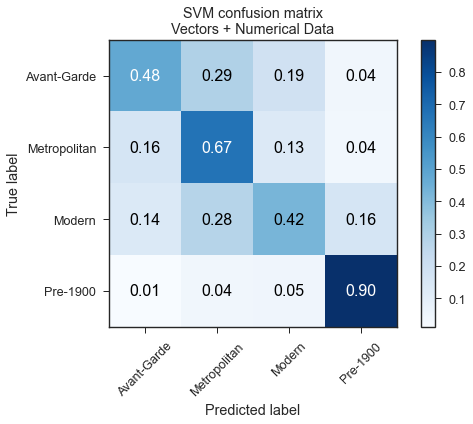

In [230]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_svm_doc)

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# # uncomment to save
plt.savefig('charts/svm_doc_untuned_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

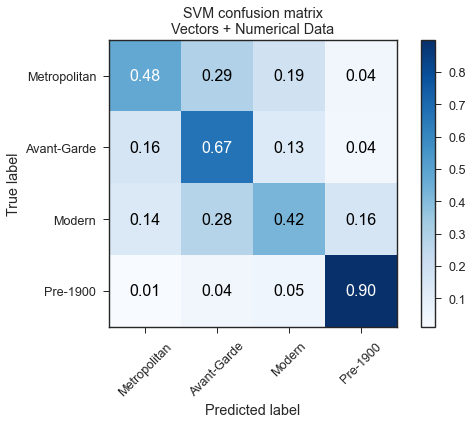

In [60]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_svm_doc)

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# # uncomment to save
plt.savefig('charts/svm_doc_untuned_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

- Interestingly tends to overpredict on Avant-Garde and has a difficult time correctly identifying Modern poetry.
- Incredible score for Pre-1900 poetry.

#### Feature importances

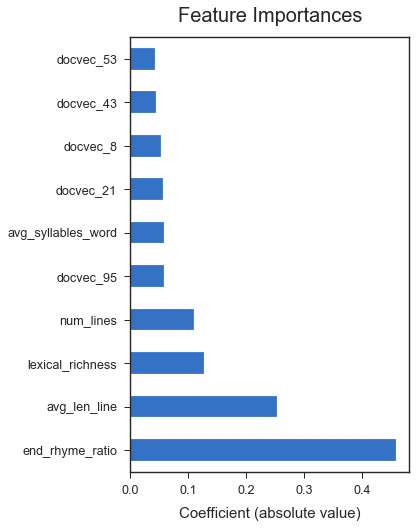

In [231]:
# top 10 features
svm_features(svm_doc, doc_train_combo.columns)

- This certainly brings my engineered features back to the forefront, with those being five out of the top ten features. The only ones not here are sentiment scores (polarity and subjectivity).
- Unfortunately, the rest of the features, being dimensions within the model, are rather enigmatic.

## XGBoost

[[go back to the top](#Predicting-Poetic-Movements)]

In [318]:
from xgboost import XGBClassifier

In [319]:


#     # instantiate svm classifiers
# xgb_vec = XGBClassifier(random_state=42)
# xgb_combo = XGBClassifier(random_state=42)

# # fit them to the training set and evaluate
# cv_scores_xgb_vec = cross_val_score(
#     xgb_vec, doc_train_vecs, y_train, 
#     scoring='f1_weighted', cv=10, n_jobs=-1
# )

# cv_scores_xgb_combo = cross_val_score(
#     xgb_combo, doc_train_combo, y_train, 
#     scoring='f1_weighted', cv=10, n_jobs=-1
# )

# # create printout
# print('-----Vectors only-----')
# print(f'All scores: {cv_scores_xgb_vec}')
# print(f'Average score: {np.mean(cv_scores_xgb_vec)}\n')
# print('------Vectors + Numerical Data-----')
# print(f'All scores: {cv_scores_xgb_combo}')
# print(f'Average score: {np.mean(cv_scores_xgb_combo)}\n')

# # instantiate baseline model
# gnb_classifier = GaussianNB()

# # cross_val_score returns a list of the scores, which I can visualize
# # to get a reasonable estimate of our classifier's performance
# cv_scores = cross_val_score(gnb_classifier, X, y, scoring=my_scorer, cv=10, n_jobs=-1)
# plt.hist(cv_scores)
# plt.title(f'Average score: {np.mean(cv_scores)}')
# plt.show();

In [320]:
# instantiate classifiers
xgb_vec = XGBClassifier(random_state=42)
xgb_combo = XGBClassifier(random_state=42)

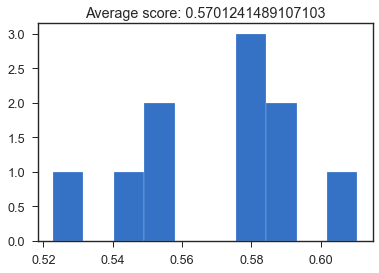

CPU times: user 217 ms, sys: 104 ms, total: 322 ms
Wall time: 32.5 s


array([0.52276249, 0.61060845, 0.55716153, 0.55122874, 0.59147519,
       0.5832838 , 0.57820265, 0.54039742, 0.57650755, 0.58961367])

In [321]:
%%time

# vectors only model
cv_plotter(xgb_vec, doc_train_vec, y_train)

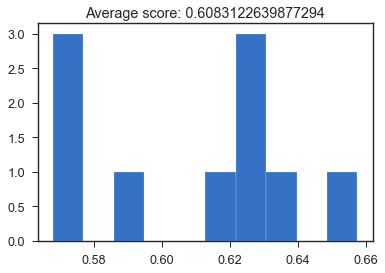

CPU times: user 197 ms, sys: 9.88 ms, total: 207 ms
Wall time: 47.6 s


array([0.56930116, 0.62418381, 0.58849968, 0.57657903, 0.62347882,
       0.65758357, 0.63395173, 0.56792251, 0.61536798, 0.62625436])

In [322]:
%%time

# combo model
cv_plotter(xgb_combo, doc_train_combo, y_train)

In [323]:
%%time

xgb = XGBClassifier(random_state=42)
xgb.fit(doc_train_combo, y_train)

CPU times: user 13 s, sys: 58.2 ms, total: 13 s
Wall time: 13.1 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [324]:
%%time

# model predictions and printout
train_preds_xgb_doc, test_preds_xgb_doc = \
    predict(xgb, 
            doc_train_combo, y_train, 
            doc_test_combo, y_test, 
            classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 0.8507739938080495
F1 score: 0.8506076288884877

-----TEST-----
Accuracy: 0.6239554317548747
F1 score: 0.6184476191937934

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

 avant_garde       0.56      0.56      0.56       239
metropolitan       0.56      0.63      0.59       268
      modern       0.59      0.47      0.52       311
    pre_1900       0.76      0.86      0.81       259

    accuracy                           0.62      1077
   macro avg       0.62      0.63      0.62      1077
weighted avg       0.62      0.62      0.62      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[135  58  41   5]
 [ 58 169  31  10]
 [ 42  70 145  54]
 [  4   5  27 223]]
CPU times: user 159 ms, sys: 3.48 ms, total: 163 ms
Wall time: 162 ms


#### Confusion matrix

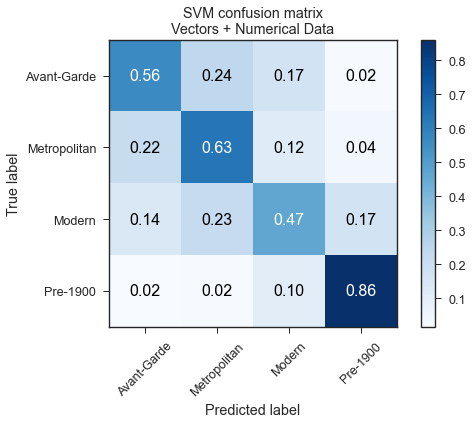

In [325]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_xgb_doc)

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# # uncomment to save
plt.savefig('charts/xgb_doc_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

## Parameter tuning

[[go back to the top](#Predicting-Poetic-Movements)]

#### Finding the best value for *C* using GridSearchCV.

In [258]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

In [301]:
doc_grid = GridSearchCV(LinearSVC(random_state=42), 
                        param_grid, 
                        scoring='f1_weighted', 
                        cv=5, n_jobs=-1, verbose=2)

In [302]:
doc_grid.fit(doc_train_combo, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=42, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=2)

In [303]:
# examine the best model
print(doc_grid.best_score_)
print(doc_grid.best_params_)
print(doc_grid.best_estimator_)

0.6294814481976287
{'C': 0.1}
LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)


- I'll run it again to try and zero in on a more specific value.

In [244]:
param_grid = {
    'C': [0.025, 0.05, 0.075, 0.1, 0.25, 0.5]
}

In [245]:
doc_grid = GridSearchCV(LinearSVC(random_state=42), 
                        param_grid, 
                        scoring='f1_weighted', 
                        cv=10, n_jobs=-1, verbose=2)

In [246]:
doc_grid.fit(doc_train_combo, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   37.7s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=42, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.025, 0.05, 0.075, 0.1, 0.25, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=2)

In [247]:
# examine the best model
print(doc_grid.best_score_)
print(doc_grid.best_params_)
print(doc_grid.best_estimator_)

0.6294048793565638
{'C': 0.1}
LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)


In [266]:
doc_grid.cv_results_

{'mean_fit_time': array([0.11620152, 0.18346431, 1.05747123, 4.50832572, 5.00701311,
        4.66279628]),
 'std_fit_time': array([0.0181995 , 0.02081257, 0.0223497 , 0.19695503, 0.27696344,
        0.48892191]),
 'mean_score_time': array([0.00725827, 0.00495415, 0.00457039, 0.0049778 , 0.00484636,
        0.00378504]),
 'std_score_time': array([0.00288623, 0.00077791, 0.00013982, 0.00035459, 0.00058305,
        0.00099921]),
 'param_C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10}],
 'split0_test_score': array([0.59308143, 0.59305893, 0.58679352, 0.58977059, 0.60994154,
        0.53172681]),
 'split1_test_score': array([0.66342393, 0.65177169, 0.67425013, 0.68347489, 0.67852006,
        0.53542141]),
 'split2_test_score': array([0.59471005, 0.58455342, 0.58138359, 0.586

In [267]:
doc_grid.scorer_

make_scorer(f1_score, pos_label=None, average=weighted)

In [309]:
%%time

# instantiate the model
svm_doc_tuned = LinearSVC(C=0.0007, random_state=42)

# fit to the training set
svm_doc_tuned.fit(doc_train_combo, y_train)

CPU times: user 112 ms, sys: 3.87 ms, total: 116 ms
Wall time: 121 ms


LinearSVC(C=0.0007, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [310]:
%%time

# model predictions and printout
train_preds_svm_doc, test_preds_svm_doc_tuned = \
    predict(svm_doc_tuned, doc_train_combo, y_train, 
            doc_test_combo, y_test, classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 0.6761609907120743
F1 score: 0.6736509590590846

-----TEST-----
Accuracy: 0.637883008356546
F1 score: 0.6315540348292353

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

 avant_garde       0.59      0.51      0.55       239
metropolitan       0.55      0.66      0.60       268
      modern       0.63      0.50      0.56       311
    pre_1900       0.77      0.89      0.83       259

    accuracy                           0.64      1077
   macro avg       0.64      0.64      0.63      1077
weighted avg       0.64      0.64      0.63      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[123  67  38  11]
 [ 44 178  36  10]
 [ 39  70 155  47]
 [  2   8  18 231]]
CPU times: user 225 ms, sys: 31.9 ms, total: 257 ms
Wall time: 66.4 ms


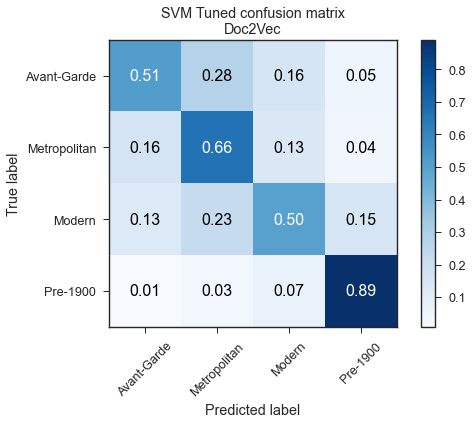

In [312]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_svm_doc_tuned)

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM Tuned confusion matrix\nDoc2Vec',
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/svm_doc_tuned_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

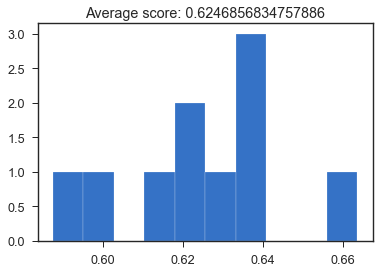

CPU times: user 170 ms, sys: 7.85 ms, total: 178 ms
Wall time: 466 ms


array([0.59657309, 0.66357196, 0.58760311, 0.61538712, 0.62858506,
       0.63782425, 0.63678824, 0.62331346, 0.62372989, 0.63348066])

In [304]:
%%time

# combo model
cv_plotter(svm_doc_tuned, doc_train_combo, y_train)

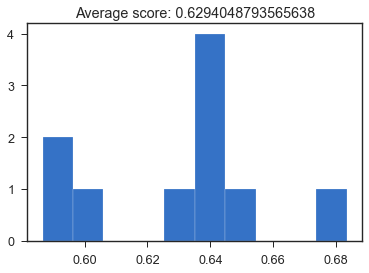

CPU times: user 159 ms, sys: 7.43 ms, total: 166 ms
Wall time: 7.41 s


array([0.58977059, 0.68347489, 0.5865958 , 0.63972401, 0.62691416,
       0.64665828, 0.64004939, 0.60250363, 0.64143221, 0.63692584])

In [305]:
%%time

# combo model
cv_plotter(doc_grid.best_estimator_, doc_train_combo, y_train)

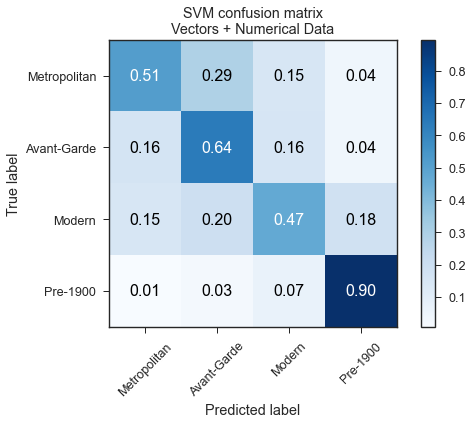

In [273]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_svm_doc)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/svm_doc_tuned_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

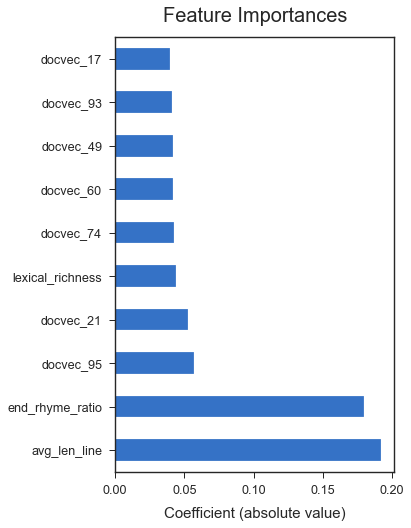

In [313]:
svm_features(svm_doc_tuned, doc_train_combo.columns)

In [ ]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_doc.coef_[0]), 
              index=doc_train_combo.columns).nlargest(10).\
              plot(kind='barh');

## Train final model

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll train a final model and save.

⏰ *NOTE: Next cell took me 1 hour and 54 minutes to run.*

## Parameter tuning

[[go back to the top](#Predicting-Poetic-Movements)]

#### Finding the best value for *C* using GridSearchCV.

In [326]:
param_grid = {
    'max_depth':[4,5,6],
    'min_child_weight':[4,5,6]
}

In [328]:
xgb_grid = GridSearchCV(XGBClassifier(random_state=42), 
                        param_grid, 
                        scoring='f1_weighted', 
                        cv=5, n_jobs=-1, verbose=2)

In [329]:
xgb_grid.fit(doc_train_combo, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=

In [330]:
# examine the best model
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
print(xgb_grid.best_estimator_)

0.6204450046905221
{'max_depth': 6, 'min_child_weight': 5}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [323]:
%%time

xgb = XGBClassifier(random_state=42)
xgb.fit(doc_train_combo, y_train)

CPU times: user 13 s, sys: 58.2 ms, total: 13 s
Wall time: 13.1 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [331]:
%%time

# model predictions and printout
train_preds_xgb_doc, test_preds_xgb_doc = \
    predict(xgb_grid.best_estimator_, 
            doc_train_combo, y_train, 
            doc_test_combo, y_test, 
            classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 0.9993808049535604
F1 score: 0.9993809318053629

-----TEST-----
Accuracy: 0.6471680594243269
F1 score: 0.6454955412822246

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

 avant_garde       0.60      0.55      0.58       239
metropolitan       0.58      0.66      0.61       268
      modern       0.62      0.56      0.59       311
    pre_1900       0.79      0.83      0.81       259

    accuracy                           0.65      1077
   macro avg       0.65      0.65      0.65      1077
weighted avg       0.65      0.65      0.65      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[132  60  39   8]
 [ 53 176  33   6]
 [ 30  64 175  42]
 [  4   5  36 214]]
CPU times: user 206 ms, sys: 3.84 ms, total: 210 ms
Wall time: 209 ms


#### Confusion matrix

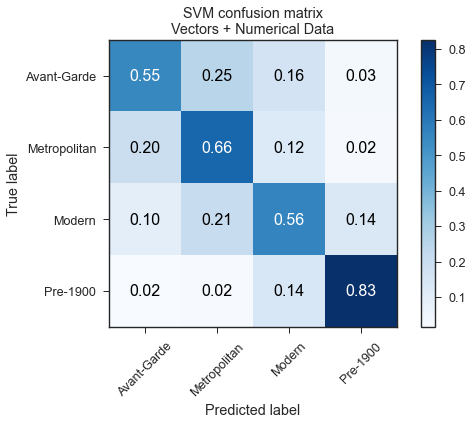

In [332]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_xgb_doc)

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# # uncomment to save
plt.savefig('charts/xgb_doc_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

In [309]:
%%time

# instantiate the model
svm_doc_tuned = LinearSVC(C=0.0007, random_state=42)

# fit to the training set
svm_doc_tuned.fit(doc_train_combo, y_train)

CPU times: user 112 ms, sys: 3.87 ms, total: 116 ms
Wall time: 121 ms


LinearSVC(C=0.0007, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [310]:
%%time

# model predictions and printout
train_preds_svm_doc, test_preds_svm_doc_tuned = \
    predict(svm_doc_tuned, doc_train_combo, y_train, 
            doc_test_combo, y_test, classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 0.6761609907120743
F1 score: 0.6736509590590846

-----TEST-----
Accuracy: 0.637883008356546
F1 score: 0.6315540348292353

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

 avant_garde       0.59      0.51      0.55       239
metropolitan       0.55      0.66      0.60       268
      modern       0.63      0.50      0.56       311
    pre_1900       0.77      0.89      0.83       259

    accuracy                           0.64      1077
   macro avg       0.64      0.64      0.63      1077
weighted avg       0.64      0.64      0.63      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[123  67  38  11]
 [ 44 178  36  10]
 [ 39  70 155  47]
 [  2   8  18 231]]
CPU times: user 225 ms, sys: 31.9 ms, total: 257 ms
Wall time: 66.4 ms


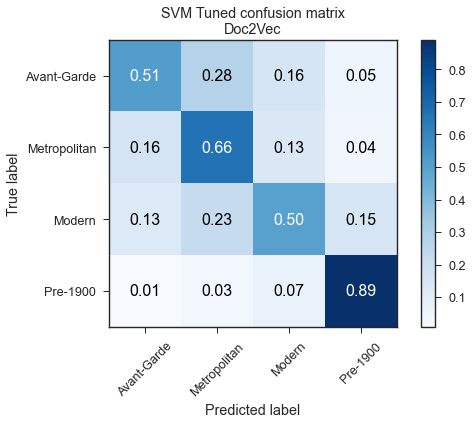

In [312]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_svm_doc_tuned)

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM Tuned confusion matrix\nDoc2Vec',
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/svm_doc_tuned_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

In [48]:
%%time

# re-create features and target
X_final = vectors_df.copy()
y = df['sentiment']

# basic decision tree with class weights balanced
final_model = DecisionTreeClassifier(class_weight='balanced', ccp_alpha=0.00005, random_state=99)

# fit model on all the data
final_model.fit(X_final, y)

# predict on train and test data
y_preds = tree_vec_tuned.predict(X_final)

print(f'F1 score: {f1_score(y, y_preds, average="weighted")}')

F1 score: 0.7696016895045278
CPU times: user 1h 52min 30s, sys: 56.4 s, total: 1h 53min 27s
Wall time: 1h 54min 4s


#### 💾 Save/Load the final model

In [49]:
# uncomment to save
with gzip.open('data/final_model.pkl', 'wb') as goodbye:
    pickle.dump(final_model, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/final_model.pkl', 'rb') as hello:
#     final_model = pickle.load(hello)

# Step 3: Reproducibility

[[go back to the top](#Predicting-Poetic-Movements)]

- Below are the required packages and other information.

In [50]:
%load_ext watermark
%watermark -a 'Joshua Szymanowski' -nmv --packages numpy,pandas,sklearn,scipy,matplotlib,seaborn,nltk,gensim,textblob,pickle,gzip

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Joshua Szymanowski Wed Aug 05 2020 

CPython 3.6.9
IPython 7.8.0

numpy 1.18.2
pandas 1.0.3
sklearn 0.0
scipy 1.4.1
matplotlib 3.2.1
seaborn 0.10.0
nltk 3.4.5
gensim 3.7.3
textblob 0.15.3
pickle unknown
gzip unknown

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


## NLP + Model version

[[go back to the top](#Predicting-Poetic-Movements)]

The following code includes all of the important work from the previous [notebook](03_nlp_features_eda.ipynb), but is not necessary to create the final model (which this code also does).

Refer to the next [section](#Model-only-version) for the code that reproduces the model only.

*NOTE: read the commented code carefully if you wish to create your own LDA topics.*

⏰ *NOTE: Next cell will take several hours to run.*

In [ ]:
%%time

# standard packages
import numpy as np
import pandas as pd

# visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')

# text processing/nlp packages
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

# modeling packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, confusion_matrix, classification_report

# saving/loading packages
import gzip
import pickle

# custom functions
from functions import *

# load dataframe
with gzip.open('data/jan_thru_may_labeled_mask_tweets.pkl', 'rb') as hello:
    df = pickle.load(hello)
    
# create stop words list
stop_words = stopwords.words('english')
# add search term words and hashtags to the list
stop_words += ['mask', '#mask',
               'masks', '#masks',
               'face', '#face',
               'facemask', '#facemask',
               'facemasks', '#facemasks', 
               'covid', '#covid',
               'covid19', '#covid19',
               'corona', '#corona',
               'coronavirus', '#coronavirus',
               'rona', '#rona',
               'virus', '#virus',
               'viral', '#viral',
               'viruses', '#viruses']
# very common/conflicting stop words discovered during eda
eda_stop_words = ['wear', 'wearing', 'get', 'one', 'people',
                  'us', 'like', 'n95', 'go', 'going', 'would', 
                  'surgical', 'via', 'also', 'use', 'even', 'know']
stop_words += eda_stop_words

# create column of processed text
df['clean_tweet'] = df['tweet'].apply(lambda x: clean_text(x, stop_words))

# custom pattern to tokenize words -- includes hashtags, words with numbers, and contractions
pattern = "(#?[a-zA-Z]+[0-9]*(?:'[a-z]+)?)"

# instantiate a document-term matrix using TfidfVectorizer
# only take words with at least 250 appearances
tf_idf = TfidfVectorizer(min_df=250, token_pattern=pattern)

# run vectorizor
data_tf_idf = tf_idf.fit_transform(df.clean_tweet)

# convert to DataFrame
data_vec = pd.DataFrame(data_tf_idf.toarray(), columns=tf_idf.get_feature_names())

    #----IMPORTANT NOTE----#
# Our corpus has changed slightly after updating the clean_text function, 
# so we will be loading the original corpus, in order to keep our original topics.
# If you wish to create new topics, uncomment commented code below.

# # one of the required inputs is a term-document matrix
# tdm = data_vec.transpose()
# tdm.head()

# # put the term-document matrix into a new gensim format, 
# # from df ==> sparse matrix ==> gensim corpus
# # NOTE: MAY TAKE A FEW MINUTES
# sparse_counts = csr_matrix(tdm)
# corpus = Sparse2Corpus(sparse_counts)

# # gensim also requires dictionary of the all terms and their respective location in the term-document matrix
# id2word = dict((v, k) for k, v in tf_idf.vocabulary_.items())

# # create the topics
# lda = LdaModel(
#                 corpus=corpus, 
#                 id2word=id2word, 
#                 num_topics=10, 
#                 passes=100, 
#                 iterations=100
#             )

    #----IMPORTANT NOTE----#
# If you chose to create your own corpus/topics, comment out these cells

# load gensim corpus
with gzip.open('data/gensim_corpus_orig.pkl', 'rb') as hello_c:
    corpus = pickle.load(hello_c)
# load vocab location dictionary
with gzip.open('data/gensim_id2word_orig.pkl', 'rb') as hello_i:
    id2word = pickle.load(hello_i)
# load topics
with gzip.open('models/lda_10topics_100passes.pkl', 'rb') as hello:
    lda = pickle.load(hello)
#-----------------------------#

# corpus from LDA model
corpus_transformed = lda[corpus]

# convert lda tuples to dictionary
lda_topics_dict = [dict(x) for x in corpus_transformed]

# convert list of lda topic weights to dataframe
lda_df = pd.DataFrame(lda_topics_dict)

# rename columns
lda_df.rename(columns={i: f'lda_{i}' for i in range(10)}, inplace=True)

# replace NaNs with 0
lda_df.fillna(0, inplace=True)

# combine with original dataframe
df = pd.concat([df, lda_df], axis=1)

# create subjectivity score column
df['subjectivity_score'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# dummy months dataframe
month_dummies = pd.get_dummies(df.month, drop_first=True)

# reformat column names
month_dummies.columns = ['february', 'march', 'april', 'may']

# combine dataframe and dummy columns; drop columns
df = pd.concat([df, month_dummies], axis=1).drop(columns='month')

# convert to categorical dummy based on whether a tweet received likes or not
df['likes'] = np.where(df.nlikes > 0, 1, 0)

# convert to categorical dummy based on whether a tweet received likes or not
df['replies'] = np.where(df.nreplies > 0, 1, 0)

# list of columns to use as features
feature_cols = [
    'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4',
    'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 
    'subjectivity_score', 'february', 'march', 
    'april', 'may', 'replies', 'likes'
]

# combine features columns and word vectors dataframe
X = pd.concat([df[feature_cols], data_vec], axis=1)
y = df['sentiment']

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# create vectors-only training and test sets (removing the first 17 columns)
X_train_vec = X_train.iloc[:,17:]
X_test_vec = X_test.iloc[:,17:]

# tuned decision tree with class weights balanced
dt_classifier = DecisionTreeClassifier(
                            class_weight='balanced',
                            ccp_alpha=0.00005,
                            random_state=99)

# fit training data
dt_classifier.fit(X_train_vec, y_train)

# predict on test data
y_preds = tree_vec.predict(X_test_vec)

# print out report for test data
print(f'F1 score: {f1_score(y_test, y_preds, average="weighted")}')
print('\n' + '-' * 100 + '\n')
print(classification_report(y_test, y_preds, target_names=y.unique()))

## Model only version

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

If you wish to reproduce only the model, use the following code.

⏰ *NOTE: Next cell will take a couple hours to run.*

In [ ]:
%%time

# standard packages
import numpy as np
import pandas as pd

# text processing/nlp packages
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# modeling packages
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score

# saving/loading packages
import gzip
import pickle

# custom functions
from functions import *

# load dataframe
with gzip.open('data/jan_thru_may_labeled_mask_tweets.pkl', 'rb') as hello:
    df = pickle.load(hello)
    
# create stop words list
stop_words = stopwords.words('english')
# add search term words and hashtags to the list
stop_words += ['mask', '#mask',
               'masks', '#masks',
               'face', '#face',
               'facemask', '#facemask',
               'facemasks', '#facemasks', 
               'covid', '#covid',
               'covid19', '#covid19',
               'corona', '#corona',
               'coronavirus', '#coronavirus',
               'rona', '#rona',
               'virus', '#virus',
               'viral', '#viral',
               'viruses', '#viruses']
# very common/conflicting stop words discovered during eda
eda_stop_words = ['wear', 'wearing', 'get', 'one', 'people',
                  'us', 'like', 'n95', 'go', 'going', 'would', 
                  'surgical', 'via', 'also', 'use', 'even', 'know']
stop_words += eda_stop_words

# create column of processed text
df['clean_tweet'] = df['tweet'].apply(lambda x: clean_text(x, stop_words))

# custom pattern to tokenize words -- includes hashtags, words with numbers, and contractions
pattern = "(#?[a-zA-Z]+[0-9]*(?:'[a-z]+)?)"

# instantiate a document-term matrix using TfidfVectorizer
# only take words with at least 250 appearances
tf_idf = TfidfVectorizer(min_df=250, token_pattern=pattern)

# run vectorizor
data_tf_idf = tf_idf.fit_transform(df.clean_tweet)

# convert to DataFrame
X_final = pd.DataFrame(data_tf_idf.toarray(), columns=tf_idf.get_feature_names())

# target variable
y = df['sentiment']

# split into train and test data
X_train_vec, X_test_vec, y_train, y_test = train_test_split(
                                                        X_final, 
                                                        y, 
                                                        test_size=0.3, 
                                                        stratify=y, 
                                                        random_state=1)

# tuned decision tree with class weights balanced
dt_classifier = DecisionTreeClassifier(
                            class_weight='balanced',
                            ccp_alpha=0.00005,
                            random_state=99)

# fit training data
dt_classifier.fit(X_train_vec, y_train)

# predict on test data
y_preds = tree_vec.predict(X_test_vec)

# print out report for test data
print(f'F1 score: {f1_score(y_test, y_preds, average="weighted")}')
print('\n' + '-' * 100 + '\n')
print(classification_report(y_test, y_preds, target_names=y.unique()))

## Conclusions

[[go back to the top](#Predicting-Poetic-Movements)]

My main takeaway is that poetry is a unique style of writing, in which form and structure (in this project representated by mostly numerical features) play a fairly significant role in categorizing into movements (and presumably on an even more micro-level into genres). Elements of form, such as the ratio of end rhymes to total lines, proportion of unique words (lexical richness), and the complexity of language (average syllables per word), played an important role in my final model. As did elements of style, such as the length of lines (measured by average words per line) and the length of the poem itself (measured by total lines).

Pre-1900 poetry is easily recognized. It tends to be longer poetry that uses a high number of end rhymes, a lot of words per line, and simpler words (fewer syllables per word). It also tends to be the most repetitious (low lexical richness score).

Avant-garde is the polar opposite. While similar to Metropolitan and Modern in terms of the number of lines, the number of words in a line is by far the lowest overall. It uses practically no end rhymes and tends to use more complex words (more syllables per word). It is also the most lexically rich movement.

Poetry is rarely neutral (and generally positive) and fairly equally subjective/objective. Pre-1900 poetry is overwhelmingly positive.

The vocabulary across movements was a mixture of visual, temporal, and ethereal words. Avant-Garde poetry tends to use more visual and temporal terms, whereas Pre-1900 poetry often used more ethereal vocabulary (*god*, *heart*, and *world*). As with most other analyses, Modern and Metropolitan are somewhere in the middle.

In the future, it would be interesting to engineer even more features, such as other types of rhyming (use of internal rhymes or slant rhymes), verb tenses, and use of white space (i.e. whether a poem always starts on the left part of the line). Topic modeling may yield some interesting results as well. 

It may also be interesting to investigate the use of stop words across movements. In my experience in poetry classes, teachers strongly encourage one to use words that make up stop words very sparingly. Perhaps this is more of the influence of Avant-Garde movements on contemporary poetry, or does Avant-Garde poetry reject a long-established rule to use fewer stop words?

## Acknowledgements

[[go back to the top](#Predicting-Poetic-Movements)]

- Thanks to [Sean Abu Wilson](https://github.com/seanabu) and [Fangfang Lee](https://github.com/jessicafangfanglee) for being great teachers.
- Thanks to the folks at [PoetryFoundation](https://www.poetryfoundation.org) for publishing poetry for well over a century and making this project possible.
- Thanks to [Sanket Doshi](https://github.com/sdoshi579) for providing the basis for my contraction dictionaries.
- Thank you to all the contributors of O'Reilly's [Practical Natural Language Processing repository](https://github.com/practical-nlp/practical-nlp).

- Finally, thanks to [Randal S. Olsen](http://www.randalolson.com/) for providing a great [example](https://nbviewer.jupyter.org/github/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb) of a machine learning notebook.

- **The number of words per line dropped down, but still in the top ten.**

# Modeling conclusions
- **Form/structure is important for prediction (especially Random Forest models).**
    - **Further exploration desired:**
        - **Other types of rhyme**
        - **Use of line breaks, tabs, and spacing**
        - **Topic modeling**
- **SVM relies mostly on vocabulary.**
    - **Further exploration desired:**
        - **Word embeddings (self-trained and pre-trained)**
        - **POS tagging**
- **SVM is the best model!**